In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats
from scipy.special import expit
from sklearn.datasets import load_boston

tf.enable_eager_execution()

graph.style.use('fivethirtyeight')

/Users/srose/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/srose/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/srose/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/srose/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/srose/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/sro

In [2]:
x, y = load_boston(return_X_y=True)

print(x.shape, y.shape)

(506, 13) (506,)


# Simple GLMs

In [3]:
%%time
model = tfp.glm.Normal()

x, y = tf.to_float(x), tf.to_float(y)
print(x.shape, y.shape)

results = tfp.glm.fit(model_matrix=x, response=y, model=model)

coef, y_pred, is_converged, n_iterations = results

(506, 13) (506,)
CPU times: user 7.27 ms, sys: 1.87 ms, total: 9.14 ms
Wall time: 7.56 ms


In [4]:
print(f'Is converged: {is_converged}')
print(f'N Iterations: {n_iterations}')

Is converged: True
N Iterations: 2


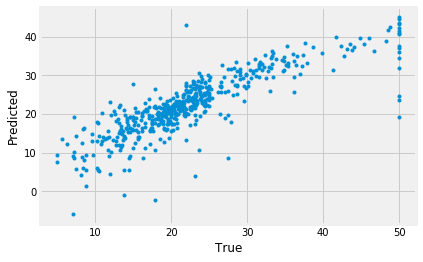

/Users/srose/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/srose/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/srose/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr

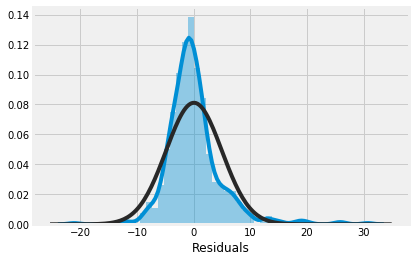

In [5]:
graph.plot(y, y_pred, '.')
graph.xlabel('True')
graph.ylabel('Predicted')
graph.show()

sns.distplot(y - y_pred, fit=stats.norm)
graph.xlabel('Residuals')
graph.show()

# Poisson Regression GLM

Problem is to predict...

$$N_{awards} \sim program + math$$

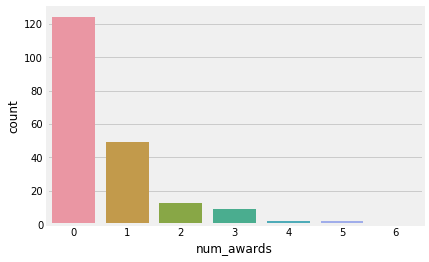

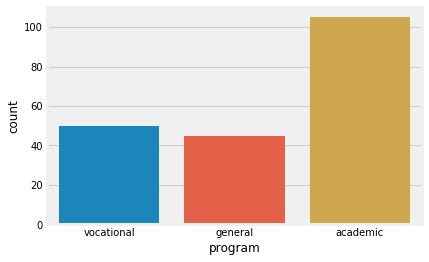

,id,num_awards,prog,math,program,academic,general,vocational
0,45,0,3,41,vocational,0,0,1
1,108,0,1,41,general,0,1,0
2,15,0,3,44,vocational,0,0,1
3,67,0,3,42,vocational,0,0,1
4,153,0,3,40,vocational,0,0,1


In [6]:
df = pd.read_csv('data/poisson_sim.csv')

# Preprocessing
df['program'] = df['prog'].map({1: 'general', 2: 'academic', 3: 'vocational'})
df = pd.concat([df, pd.get_dummies(df['program'])], axis='columns')

sns.countplot(df['num_awards'])
graph.show()

sns.countplot(df['program'])
graph.show()

display(df.head())

In [7]:
y = df['num_awards']
x = df[['math', 'academic', 'vocational']].copy()
x['neither'] = 1

In [8]:
%%time
poisson_model = tfp.glm.Poisson()

results = tfp.glm.fit(tf.to_float(x.values), tf.to_float(y.values), model=poisson_model)

coef, y_pred, is_converged, n_iterations = results

CPU times: user 10.2 ms, sys: 1.1 ms, total: 11.3 ms
Wall time: 10.3 ms


In [9]:
print(f'Is converged: {is_converged}')
print(f'N Iterations: {n_iterations}')
print('Coefs')
print(coef)

Is converged: True
N Iterations: 6
Coefs
tf.Tensor([ 0.07015231  1.0838615   0.36981094 -5.2471213 ], shape=(4,), dtype=float32)


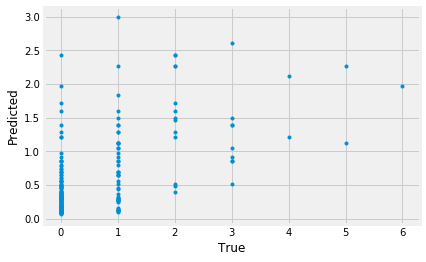

/Users/srose/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/srose/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/srose/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr

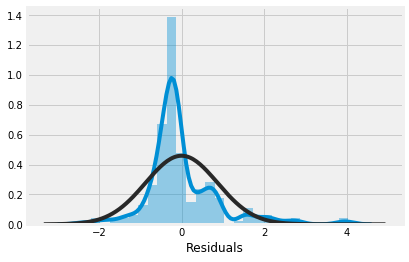

In [10]:
graph.plot(y, np.exp(y_pred), '.')
graph.xlabel('True')
graph.ylabel('Predicted')
graph.show()

sns.distplot(y - np.exp(y_pred), fit=stats.norm)
graph.xlabel('Residuals')
graph.show()

# Markov Chain Monte Carlo in Tensorflow

It won't be as easy as PyMC3 but atleast I can anything.